# Model Building

## Setup

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import zipfile
import ast
from datetime import datetime

pd.set_option('display.max_columns', None)

### Import Datasets (sourced NYT API)

In [3]:
fp = pd.read_csv("front_pages")
fp['target'] = 1 #denote front page article
rp = pd.read_csv("regular_pages")
rp['target'] = 0 #denote regular page article
df = pd.concat([fp,rp])


/var/folders/tv/7ydtp1js41qb0mxn5cql9tkr0000gn/T/ipykernel_95890/220859064.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  rp = pd.read_csv("regular_pages")


### Functions

In [14]:
def extract_main_headline(row_headline):
    try:
        # Ensure the row_headline is a valid string representation of a dictionary
        if isinstance(row_headline, str):
            headline_dict = ast.literal_eval(row_headline)
            return headline_dict.get('main')
    except (ValueError, SyntaxError):
        # Return None or a default value if parsing fails
        return None
    
from tensorflow.keras.utils import Sequence

class BalancedSequenceGenerator(Sequence):
    def __init__(self, features, labels, batch_size, sequence_length, balance=False):
        self.labels = labels
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.balance = balance
        self.features = features

        self.indices = np.arange(len(self.features) - self.sequence_length + 1)
        if self.balance:  # Use for training
            self._balance_data()

        # Initialize StringLookup layers with vocabularies
        self.section_name_lookup = tf.keras.layers.StringLookup(vocabulary=sectionname_vocab, oov_token='OOV', dtype='int64')
        self.news_desk_lookup = tf.keras.layers.StringLookup(vocabulary=newsdesk_vocab, oov_token='OOV', dtype='int64')
        self.type_of_material_lookup = tf.keras.layers.StringLookup(vocabulary=tom_vocab, oov_token='OOV', dtype='int64')

        # Attributes to store batches
        self.batch_features = []
        self.batch_labels = []

        # Precompute all batches
        self._precompute_batches()

    def _balance_data(self):
        df = pd.concat([self.features, self.labels], axis=1)
        majority_class = df['target'].value_counts().idxmax()
        minority_class = df['target'].value_counts().idxmin()

        df_majority = df[df['target'] == majority_class]
        df_minority = df[df['target'] == minority_class]

        target_minority_count = int(len(df_majority) * 0.4 / 0.6)

        if len(df_minority) < target_minority_count:
            df_minority_resampled = resample(df_minority,
                                             replace=True,
                                             n_samples=target_minority_count,
                                             random_state=42)
        else:
            df_minority_resampled = resample(df_minority,
                                             replace=False,
                                             n_samples=target_minority_count,
                                             random_state=42)

        df_balanced = pd.concat([df_majority, df_minority_resampled])
        self.features = df_balanced.drop(columns=['target'])
        self.labels = df_balanced['target']

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def _precompute_batches(self):
        for idx in range(len(self)):
            batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_features = []
            batch_labels = []

            for ind in batch_indices:
                start_idx = ind
                end_idx = start_idx + self.sequence_length

                # Ensure the indices are within bounds
                if end_idx > len(self.features):
                    continue

                # Extract cols
                section_name = self.features.iloc[start_idx:end_idx, 0].values
                news_desk = self.features.iloc[start_idx:end_idx, 1].values
                type_of_material = self.features.iloc[start_idx:end_idx, 2].values

                # One-hot encoding of categoricals using the vocabularies
                section_name_oh = self.section_name_lookup(section_name).numpy().reshape(-1, 1)
                news_desk_oh = self.news_desk_lookup(news_desk).numpy().reshape(-1, 1)
                type_of_material_oh = self.type_of_material_lookup(type_of_material).numpy().reshape(-1, 1)

                # Extract non-OH features
                word_count = self.features.iloc[start_idx:end_idx, 3].values.reshape(-1, 1)
                num_subjects = self.features.iloc[start_idx:end_idx, 4].values.reshape(-1, 1)
                num_persons = self.features.iloc[start_idx:end_idx, 5].values.reshape(-1, 1)
                num_glocs = self.features.iloc[start_idx:end_idx, 6].values.reshape(-1, 1)
                dv_mean = np.vstack(self.features.iloc[start_idx:end_idx, 7].values)

                # Prepare feature set
                features = np.concatenate([section_name_oh, news_desk_oh, type_of_material_oh,
                                           word_count, num_subjects, num_persons, num_glocs, dv_mean], axis=-1)

                batch_features.append(features)
                batch_labels.append(self.labels.iloc[end_idx - 1])  # Label for the end of the sequence

            # Store the precomputed batches
            self.batch_features.append(np.array(batch_features, dtype='float64'))
            self.batch_labels.append(np.array(batch_labels, dtype='float64'))

    def __getitem__(self, idx):
        if idx >= len(self.batch_features) or idx >= len(self.batch_labels):
            raise IndexError("Index out of range for precomputed batches")

        return self.batch_features[idx], self.batch_labels[idx]
    
# Function to calculate precision, recall, accuracy, and F1-scores
def calculate_scores(y_true, y_pred):
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

# Function to save model scores to a CSV file
def save_model_scores(model_name, X, y_true, y_pred, note, output_file='model_scores.csv'):
    precision, recall, f1, accuracy = calculate_scores(y_true, y_pred)
    features = X.columns.tolist() if hasattr(X, 'columns') else [f"Feature_{i}" for i in range(X.shape[1])]
    
    model_info = {
        'Model Name': model_name,
        'Date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'Features': ', '.join(features),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Note': note
    }
    
    df = pd.DataFrame([model_info])
    
    if not os.path.exists(output_file):
        df.to_csv(output_file, index=False)
    else:
        existing_df = pd.read_csv(output_file)
        if model_name not in existing_df['Model Name'].values:
            df.to_csv(output_file, mode='a', index=False, header=False)

## Text Preparation

In [4]:
df.loc[385091, 'headline'] = df.loc[385091, 'print_page']
df.loc[385091, 'pub_date'] = df.loc[385091, 'multimedia']
df = df[~df['headline'].isnull()]
df['year'] = pd.to_datetime(df['pub_date'], errors='coerce').dt.year

# Sort the dataset by date
df = df.sort_values(by='pub_date')

#### Remove Document Types : Multimedia and Audio

In [6]:
# Remove rows where document_type is 'multimedia' or 'audio'
df = df[~df['document_type'].isin(['multimedia', 'audio'])]

In [7]:
# Reset
df = df.reset_index(drop=True)

### Select Target Variable : Front Page versus Non-Front Page

In [7]:
df2 = pd.DataFrame()
df2['target'] = df['target']

### Feature Engineering

In [52]:
# Year (for Train Split)
df2['year'] = df['year']
df2['pub_date'] = df['pub_date']

# Headline
df2['headline'] = df['headline']
df2['main_headlines'] = df['headline'].apply(lambda row_headline: extract_main_headline(row_headline))

# Snippet
df2['snippet'] = df['snippet']

# Lead_Paragraph
df2['lead_paragraph'] = df['lead_paragraph']

# Combine text columns
df2['combined_text'] = df2['main_headlines'] + ' ' + df2['snippet'] + ' ' + df2['lead_paragraph']

# include categorical data
df2['section_name'] = df['section_name']
df2['news_desk'] = df['news_desk']
df2['type_of_material'] = df['type_of_material']

# include word_count for numerical data
df2['word_count'] = df['word_count']



## Baseline

In [10]:
from sklearn.metrics import classification_report
from datetime import datetime

# Define the output file name
output_file = 'model_scores.csv'

# Baseline predictions (predict all targets as 0)
y_val_baseline = np.zeros_like(df2['target'])

# Evaluate the baseline model
baseline_report = classification_report(df2['target'], y_val_baseline, output_dict=True)
baseline_precision = baseline_report['macro avg']['precision']
baseline_recall = baseline_report['macro avg']['recall']
baseline_f1 = baseline_report['macro avg']['f1-score']
baseline_accuracy = baseline_report['accuracy']

# Define the model details
model_name = "Baseline Model (Predict All Zeros)"
note = "Predicts all targets as 0"

# Extract features
features_used = ', '.join(df2.iloc[:, 1:].columns)

# Create a dictionary with the results
results = {
    'Model Name': model_name,
    'Date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Features': features_used,
    'Accuracy': baseline_accuracy,
    'Precision': baseline_precision,
    'Recall': baseline_recall,
    'F1-Score': baseline_f1,
    'Note': note
}

# Check if the output file exists and whether the model name is already present
if os.path.exists(output_file):
    existing_df = pd.read_csv(output_file)
    if model_name in existing_df['Model Name'].values:
        print(f"Model {model_name} already exists in {output_file}. Skipping append.")
    else:
        # Append the new results to the existing CSV
        results_df = pd.DataFrame([results])
        results_df.to_csv(output_file, index=False, mode='a', header=False)
else:
    # If the file does not exist, create it with the new results
    results_df = pd.DataFrame([results])
    results_df.to_csv(output_file, index=False, mode='a', header=True)

print(f"Results for {model_name} written to '{output_file}'.")

/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Baseline Model (Predict All Zeros) already exists in model_scores.csv. Skipping append.
Results for Baseline Model (Predict All Zeros) written to 'model_scores.csv'.


/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Always Predict 0

In [70]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Baseline predictions (predict all targets as 0)
y_val_baseline = np.zeros_like(df2['target'])

# Evaluate the baseline model with class 1 as positive label
baseline_precision = precision_score(df2['target'], y_val_baseline, pos_label=1)
baseline_recall = recall_score(df2['target'], y_val_baseline, pos_label=1)
baseline_f1 = f1_score(df2['target'], y_val_baseline, pos_label=1)
baseline_accuracy = accuracy_score(df2['target'], y_val_baseline)

# Define the model details
model_name = "Baseline Model (Predict All Zeros)"
note = "Predicts all targets as 0"

# Print the model details and metrics
print(model_name)
print(note)
print(f"Baseline Precision: {baseline_precision:.4f}")
print(f"Baseline Recall: {baseline_recall:.4f}")
print(f"Baseline F1-Score: {baseline_f1:.4f}")
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

Baseline Model (Predict All Zeros)
Predicts all targets as 0
Baseline Precision: 0.0000
Baseline Recall: 0.0000
Baseline F1-Score: 0.0000
Baseline Accuracy: 0.9445


/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Predict based on class distribution

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Calculate the proportion of class 1 in the dataset
p_1 = df2['target'].mean()  # This gives the proportion of 1s

# Generate random predictions based on the proportion of class 1
y_val_baseline = np.random.choice([0, 1], size=len(df2['target']), p=[1-p_1, p_1])

# Evaluate the baseline model with class 1 as positive label
baseline_precision = precision_score(df2['target'], y_val_baseline, pos_label=1)
baseline_recall = recall_score(df2['target'], y_val_baseline, pos_label=1)
baseline_f1 = f1_score(df2['target'], y_val_baseline, pos_label=1)
baseline_accuracy = accuracy_score(df2['target'], y_val_baseline)

# Define the model details
model_name = "Baseline Model (Random Prediction)"
note = f"Predicts 0 or 1 randomly with p(1) = {p_1:.2f}"

# Print the model details and metrics
print(model_name)
print(note)
print(f"Baseline Precision: {baseline_precision:.4f}")
print(f"Baseline Recall: {baseline_recall:.4f}")
print(f"Baseline F1-Score: {baseline_f1:.4f}")
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

Baseline Model (Random Prediction)
Predicts 0 or 1 randomly with p(1) = 0.05
Baseline Precision: 0.0476
Baseline Recall: 0.0475
Baseline F1-Score: 0.0476
Baseline Accuracy: 0.9081


#### Train/Val and Test Split

In [53]:
# Function to split the dataset based on years
def split_data_by_year(df, dropnulls = False):
    if dropnulls==True:
        df = df.dropna()
    training_val_set = df[df['year'] <= 2023]
    test_set = df[df['year'] == 2024]
    
    return training_val_set, test_set

# Split the dataset
train_val, test = split_data_by_year(df2, dropnulls = True)

## Balancing Dataset

In [54]:
from sklearn.utils import resample

def oversample_minority_to_target(df, target_column, features_to_balance, target_ratio=0.8):
    # Identify the counts of the majority and minority classes
    majority_class_count = df[target_column].value_counts().max()
    minority_class_count = df[target_column].value_counts().min()

    # Calculate the target number of samples for the minority class
    target_minority_count = int(majority_class_count * target_ratio)

    # Filter out the minority class samples
    minority_class_df = df[df[target_column] == df[target_column].value_counts().idxmin()]

    # Initialize a DataFrame to store the oversampled data
    oversampled_df = pd.DataFrame()

    # Oversample the minority class
    for feature in features_to_balance:
        feature_value_counts = minority_class_df[feature].value_counts(normalize=True)
        for value, proportion in feature_value_counts.items():
            n_samples = int(target_minority_count * proportion)
            samples_to_add = minority_class_df[minority_class_df[feature] == value]
            if len(samples_to_add) < n_samples:
                # Oversample with replacement if necessary
                samples_to_add = resample(samples_to_add,
                                          replace=True,
                                          n_samples=n_samples,
                                          random_state=42)
            oversampled_df = pd.concat([oversampled_df, samples_to_add])

    # Combine the oversampled data with the majority class
    majority_class_df = df[df[target_column] == df[target_column].value_counts().idxmax()]
    balanced_df = pd.concat([oversampled_df, majority_class_df])

    # Shuffle the dataset to ensure random distribution
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

#### PLEASE NOTE
The following code has been modified to exclude the balancing technique mentioned earlier, as it led to overfitting and poor generalization compared to not balancing the dataset. As a result, I’ve left that out of the final code, although the oversample_minority_to_target function is still included above for reference.

## Modeling Techniques

### (CountVectorizer) Logistic Regression

In [55]:
train_val.columns

Index(['target', 'year', 'headline', 'main_headlines', 'snippet',
       'lead_paragraph', 'combined_text', 'section_name', 'news_desk',
       'type_of_material', 'word_count', 'pub_date'],
      dtype='object')

In [83]:
# Split the dataset
train_val, test = split_data_by_year(df2, dropnulls = True)
print(train_val.columns)

# Select Features
text_features = ['combined_text']
num_features = ['word_count']
cat_features = ['section_name','news_desk', 'type_of_material']

# Apply the function to balance your dataset
balanced_train_val = oversample_minority_to_target(train_val, 'target', ['section_name', 'type_of_material', 'news_desk'], target_ratio=0.3)
balanced_train_val = balanced_train_val.sort_values(by='pub_date').reset_index(drop=True)

# X = balanced_train_val[text_features + num_features + cat_features]
# y = balanced_train_val['target']

X = train_val[text_features + num_features + cat_features]
y = train_val['target']

print(train_val.shape)
print(balanced_train_val.shape)

display(train_val['target'].value_counts(normalize=True))
display(balanced_train_val['target'].value_counts(normalize=True))

Index(['target', 'year', 'headline', 'main_headlines', 'snippet',
       'lead_paragraph', 'combined_text', 'section_name', 'news_desk',
       'type_of_material', 'word_count', 'pub_date'],
      dtype='object')
(396659, 12)
(714002, 12)


target
0    0.947449
1    0.052551
Name: proportion, dtype: float64

target
0    0.526349
1    0.473651
Name: proportion, dtype: float64

In [84]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import FeatureUnion

# Ensure no missing values
train_val[text_features + num_features + cat_features] = train_val[text_features + num_features + cat_features].fillna('')

X = train_val[text_features + num_features + cat_features]
y = train_val['target']

text_vectorizer = CountVectorizer()
num_scaler = StandardScaler()
cat_encoder = OneHotEncoder(handle_unknown='ignore')

# ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_vectorizer, 'combined_text'),
        ('num', num_scaler, num_features),
        ('cat', cat_encoder, cat_features)
    ],
    remainder='passthrough'  # To ensure no columns are dropped
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

tscv = TimeSeriesSplit(n_splits=5)

# Initialize variables to store the best model and scores
best_model = None
best_score = -1
best_params = None
train_model_scores = []
model_scores = []


for train_idx, val_idx in tscv.split(train_val):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline.fit(X_train, y_train)
    y_val_train = pipeline.predict(X)
    y_val_pred = pipeline.predict(X_val)

    # Calculate scores
    train_precision, train_recall, train_f1, train_accuracy = calculate_scores(y_val, y_val_pred)
    precision, recall, f1, accuracy = calculate_scores(y_val, y_val_pred)
    train_model_scores.append((pipeline, train_precision, train_recall, train_f1, accuracy))
    model_scores.append((pipeline, precision, recall, f1, accuracy))
    print(model_scores)

    # Update the best model if current model is better
    if f1 > best_score:
        best_model = pipeline
        best_score = f1
        best_params = pipeline.get_params()

# Let's use exponential weighting with alpha = 0.9
alpha = 0.9 # Can be hyper-parameterized
num_splits = len(model_scores)

# Calculate weights based on exponential decay
weights = np.array([alpha**i for i in range(num_splits)])
weights = weights / weights.sum()  # Normalize weights to sum to 1

# Extract the scores for each metric from model_scores
precision_scores = np.array([score[1] for score in train_model_scores])
recall_scores = np.array([score[2] for score in train_model_scores])
f1_scores = np.array([score[3] for score in train_model_scores])
accuracy_scores = np.array([score[4] for score in train_model_scores])

# Calculate weighted averages for each metric
avg_precision = np.dot(precision_scores, weights)
avg_recall = np.dot(recall_scores, weights)
avg_f1 = np.dot(f1_scores, weights)
avg_accuracy = np.dot(accuracy_scores, weights)

print(f"Average Precision (train): {avg_precision:.4f}")
print(f"Average Recall (train): {avg_recall:.4f}")
print(f"Average F1-Score (train): {avg_f1:.4f}")
print(f"Average Accuracy (train): {avg_accuracy:.4f}")

# Let's use exponential weighting with alpha = 0.9
alpha = 0.9 # Can be hyper-parameterized
num_splits = len(model_scores)

# Calculate weights based on exponential decay
weights = np.array([alpha**i for i in range(num_splits)])
weights = weights / weights.sum()  # Normalize weights to sum to 1

# Extract the scores for each metric from model_scores
precision_scores = np.array([score[1] for score in model_scores])
recall_scores = np.array([score[2] for score in model_scores])
f1_scores = np.array([score[3] for score in model_scores])
accuracy_scores = np.array([score[4] for score in model_scores])

# Calculate weighted averages for each metric
avg_precision = np.dot(precision_scores, weights)
avg_recall = np.dot(recall_scores, weights)
avg_f1 = np.dot(f1_scores, weights)
avg_accuracy = np.dot(accuracy_scores, weights)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")

# print(f"Best Model Params: {best_params}")
y_val_pred = best_model.predict(X_val)
 
model_name = "Logistic Regression CountVectorizer (wght_decay) (score_change)"
note = "score_change, Including word_count + news_desk + section_name (wght_decay) (score_change)"
save_model_scores(model_name, X_val, y_val, y_val_pred, note, output_file='model_scores.csv')

[(Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', CountVectorizer(),
                                                  'combined_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['section_name', 'news_desk',
                                                   'type_of_material'])])),
                ('classifier', LogisticRegression())]), 0.7603195739014648, 0.6523229246001523, 0.7021930723508916, 0.9780211468937664)]


/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[(Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', CountVectorizer(),
                                                  'combined_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['section_name', 'news_desk',
                                                   'type_of_material'])])),
                ('classifier', LogisticRegression())]), 0.7603195739014648, 0.6523229246001523, 0.7021930723508916, 0.9780211468937664), (Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', CountVectorizer(),
       

/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[(Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', CountVectorizer(),
                                                  'combined_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['section_name', 'news_desk',
                                                   'type_of_material'])])),
                ('classifier', LogisticRegression())]), 0.7603195739014648, 0.6523229246001523, 0.7021930723508916, 0.9780211468937664), (Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', CountVectorizer(),
       

/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[(Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', CountVectorizer(),
                                                  'combined_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['section_name', 'news_desk',
                                                   'type_of_material'])])),
                ('classifier', LogisticRegression())]), 0.7603195739014648, 0.6523229246001523, 0.7021930723508916, 0.9780211468937664), (Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', CountVectorizer(),
       

/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[(Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', CountVectorizer(),
                                                  'combined_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['section_name', 'news_desk',
                                                   'type_of_material'])])),
                ('classifier', LogisticRegression())]), 0.7603195739014648, 0.6523229246001523, 0.7021930723508916, 0.9780211468937664), (Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', CountVectorizer(),
       

/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf


Baseline model classification report (predict all 0s):
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     61727
           1       0.00      0.00      0.00      4382

    accuracy                           0.93     66109
   macro avg       0.47      0.50      0.48     66109
weighted avg       0.87      0.93      0.90     66109



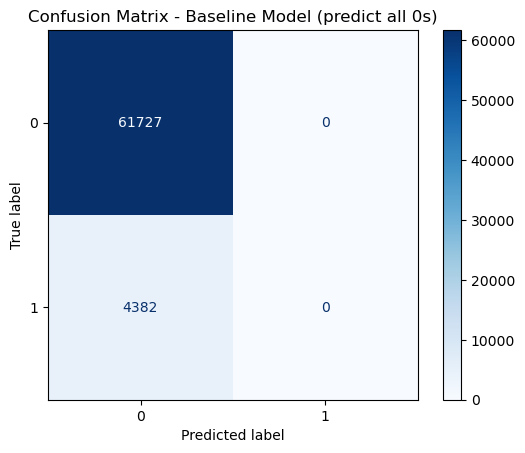


Percentage Improvement Compared to Baseline:
Precision Improvement: 52.02%
Recall Improvement: 26.20%
F1-Score Improvement: 138.02%

Model classification report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     61727
           1       0.71      0.61      0.65      4382

    accuracy                           0.96     66109
   macro avg       0.84      0.79      0.82     66109
weighted avg       0.95      0.96      0.96     66109



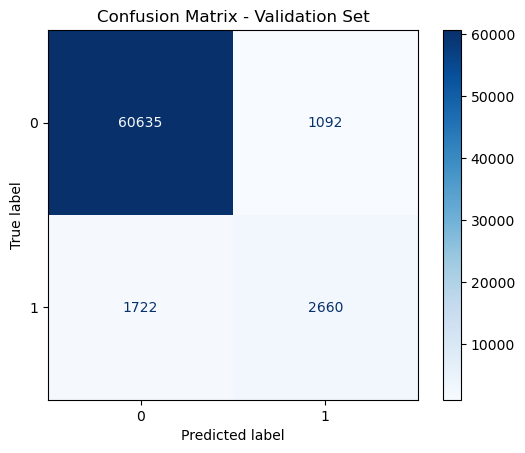

In [85]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_val_baseline = np.zeros_like(y_val)
baseline_report = classification_report(y_val, y_val_baseline, output_dict=True)
baseline_precision = baseline_report['macro avg']['precision']
baseline_recall = baseline_report['macro avg']['recall']
baseline_f1 = baseline_report['macro avg']['f1-score']

print("\nBaseline model classification report (predict all 0s):")
print(classification_report(y_val, y_val_baseline))

cm_baseline = confusion_matrix(y_val, y_val_baseline)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline)
disp_baseline.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Baseline Model (predict all 0s)")
plt.show()

print("\nPercentage Improvement Compared to Baseline:")
print(f"Precision Improvement: {((avg_precision - baseline_precision) / baseline_precision) * 100:.2f}%")
print(f"Recall Improvement: {((avg_recall - baseline_recall) / baseline_recall) * 100:.2f}%")
print(f"F1-Score Improvement: {(avg_f1 / baseline_f1) * 100:.2f}%")

print("\nModel classification report:")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

### (TF-IDF) Logistic Regression

In [86]:
# Split the dataset
train_val, test = split_data_by_year(df2, dropnulls = True)
print(train_val.columns)

# Select Features
text_features = ['combined_text']
num_features = ['word_count']
cat_features = ['section_name','news_desk', 'type_of_material']

# Apply the function to balance your dataset
balanced_train_val = oversample_minority_to_target(train_val, 'target', ['section_name', 'type_of_material', 'news_desk'], target_ratio=0.6)
balanced_train_val = balanced_train_val.sort_values(by='pub_date').reset_index(drop=True)

# X = balanced_train_val[text_features + num_features + cat_features]
# y = balanced_train_val['target']
X = train_val[text_features + num_features + cat_features]
y = train_val['target']

print(train_val.shape)
print(balanced_train_val.shape)

display(train_val['target'].value_counts(normalize=True))
display(balanced_train_val['target'].value_counts(normalize=True))

Index(['target', 'year', 'headline', 'main_headlines', 'snippet',
       'lead_paragraph', 'combined_text', 'section_name', 'news_desk',
       'type_of_material', 'word_count', 'pub_date'],
      dtype='object')
(396659, 12)
(1052227, 12)


target
0    0.947449
1    0.052551
Name: proportion, dtype: float64

target
1    0.642839
0    0.357161
Name: proportion, dtype: float64

In [87]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ensure no missing values
train_val[text_features + num_features + cat_features] = train_val[text_features + num_features + cat_features].fillna('')

X = train_val[text_features + num_features + cat_features]
y = train_val['target']

# text_vectorizer = CountVectorizer()
text_vectorizer = TfidfVectorizer()
num_scaler = StandardScaler()
cat_encoder = OneHotEncoder(handle_unknown='ignore')

# ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_vectorizer, 'combined_text'),
        ('num', num_scaler, num_features),
        ('cat', cat_encoder, cat_features)
    ],
    remainder='passthrough'  # To ensure no columns are dropped
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

tscv = TimeSeriesSplit(n_splits=5)

# Initialize variables to store the best model and scores
best_model = None
best_score = -1
best_params = None
model_scores = []


for train_idx, val_idx in tscv.split(train_val):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict(X_val)

    # Calculate scores
    precision, recall, f1, accuracy = calculate_scores(y_val, y_val_pred)
    model_scores.append((pipeline, precision, recall, f1, accuracy))
    print(model_scores)

    # Update the best model if current model is better
    if f1 > best_score:
        best_model = pipeline
        best_score = f1
        best_params = pipeline.get_params()

# Let's use exponential weighting with alpha = 0.9
alpha = 0.9 # Can be hyper-parameterized
num_splits = len(model_scores)

# Calculate weights based on exponential decay
weights = np.array([alpha**i for i in range(num_splits)])
weights = weights / weights.sum()  # Normalize weights to sum to 1

# Extract the scores for each metric from model_scores
precision_scores = np.array([score[1] for score in train_model_scores])
recall_scores = np.array([score[2] for score in train_model_scores])
f1_scores = np.array([score[3] for score in train_model_scores])
accuracy_scores = np.array([score[4] for score in train_model_scores])

# Calculate weighted averages for each metric
avg_precision = np.dot(precision_scores, weights)
avg_recall = np.dot(recall_scores, weights)
avg_f1 = np.dot(f1_scores, weights)
avg_accuracy = np.dot(accuracy_scores, weights)

print(f"Average Precision (train): {avg_precision:.4f}")
print(f"Average Recall (train): {avg_recall:.4f}")
print(f"Average F1-Score (train): {avg_f1:.4f}")
print(f"Average Accuracy (train): {avg_accuracy:.4f}")

# Let's use exponential weighting with alpha = 0.9
alpha = 0.9 # Can be hyper-parameterized
num_splits = len(model_scores)

# Calculate weights based on exponential decay
weights = np.array([alpha**i for i in range(num_splits)])
weights = weights / weights.sum()  # Normalize weights to sum to 1

# Extract the scores for each metric from model_scores
precision_scores = np.array([score[1] for score in model_scores])
recall_scores = np.array([score[2] for score in model_scores])
f1_scores = np.array([score[3] for score in model_scores])
accuracy_scores = np.array([score[4] for score in model_scores])

# Calculate weighted averages for each metric
avg_precision = np.dot(precision_scores, weights)
avg_recall = np.dot(recall_scores, weights)
avg_f1 = np.dot(f1_scores, weights)
avg_accuracy = np.dot(accuracy_scores, weights)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")

# print(f"Best Model Params: {best_params}")
y_val_pred = best_model.predict(X_val)

model_name = "Logistic Regression TFIDF (score_change)"
note = "score_change, TFIDF combinedtext + word_count + news_desk + section_name"
save_model_scores(model_name, X_val, y_val, y_val_pred, note, output_file='model_scores.csv')

[(Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'combined_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['section_name', 'news_desk',
                                                   'type_of_material'])])),
                ('classifier', LogisticRegression())]), 0.8725490196078431, 0.7117288651942117, 0.7839765100671141, 0.9844196705441014)]
[(Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
      

/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[(Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'combined_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['section_name', 'news_desk',
                                                   'type_of_material'])])),
                ('classifier', LogisticRegression())]), 0.8725490196078431, 0.7117288651942117, 0.7839765100671141, 0.9844196705441014), (Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
       


Baseline model classification report (predict all 0s):
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     61727
           1       0.00      0.00      0.00      4382

    accuracy                           0.93     66109
   macro avg       0.47      0.50      0.48     66109
weighted avg       0.87      0.93      0.90     66109



/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

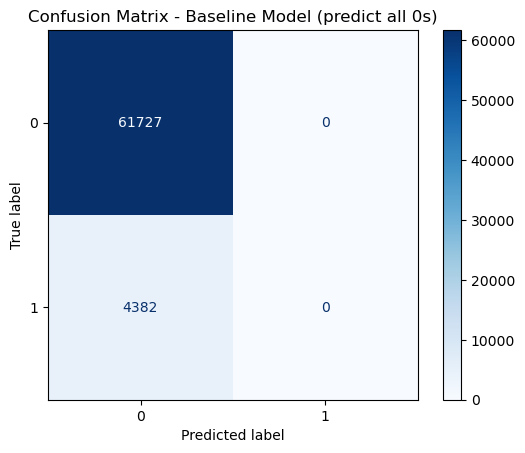


Percentage Improvement Compared to Baseline:
Precision Improvement: 70.48%
Recall Improvement: 31.85%
F1-Score Improvement: 148.98%

Model classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     61727
           1       0.81      0.60      0.69      4382

    accuracy                           0.96     66109
   macro avg       0.89      0.80      0.84     66109
weighted avg       0.96      0.96      0.96     66109



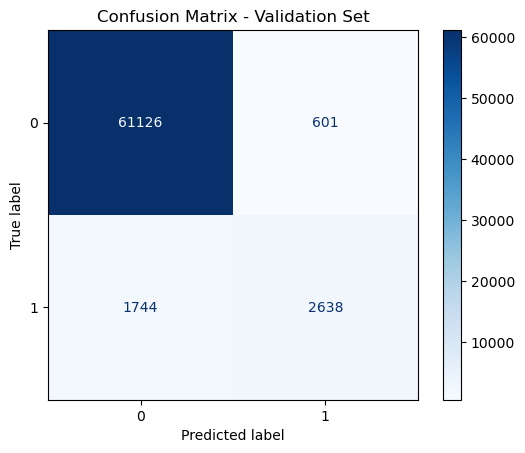

In [88]:
y_val_baseline = np.zeros_like(y_val)
baseline_report = classification_report(y_val, y_val_baseline, output_dict=True)
baseline_precision = baseline_report['macro avg']['precision']
baseline_recall = baseline_report['macro avg']['recall']
baseline_f1 = baseline_report['macro avg']['f1-score']

print("\nBaseline model classification report (predict all 0s):")
print(classification_report(y_val, y_val_baseline))

cm_baseline = confusion_matrix(y_val, y_val_baseline)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline)
disp_baseline.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Baseline Model (predict all 0s)")
plt.show()

print("\nPercentage Improvement Compared to Baseline:")
print(f"Precision Improvement: {((avg_precision - baseline_precision) / baseline_precision) * 100:.2f}%")
print(f"Recall Improvement: {((avg_recall - baseline_recall) / baseline_recall) * 100:.2f}%")
print(f"F1-Score Improvement: {(avg_f1 / baseline_f1) * 100:.2f}%")

print("\nModel classification report:")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

### Grid Search Logistic Regression

In [81]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__tol': [1e-3, 1e-2],
    'classifier__C': [1],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'classifier__max_iter': [10, 25, 50],
    'classifier__random_state': [42]
}

# Define the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='f1', n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/svm/_base.py

Best parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__max_iter': 25, 'classifier__penalty': 'l1', 'classifier__random_state': 42, 'classifier__solver': 'liblinear', 'classifier__tol': 0.001}
Best F1 score: 0.7180805527221437


In [89]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ensure no missing values
train_val[text_features + num_features + cat_features] = train_val[text_features + num_features + cat_features].fillna('')

X = train_val[text_features + num_features + cat_features]
y = train_val['target']

# text_vectorizer = CountVectorizer()
text_vectorizer = TfidfVectorizer()
num_scaler = StandardScaler()
cat_encoder = OneHotEncoder(handle_unknown='ignore')

# ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_vectorizer, 'combined_text'),
        ('num', num_scaler, num_features),
        ('cat', cat_encoder, cat_features)
    ],
    remainder='passthrough'  # To ensure no columns are dropped
)
# Best parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__max_iter': 25, 'classifier__penalty': 'l1', 'classifier__random_state': 42, 'classifier__solver': 'liblinear', 'classifier__tol': 0.001}
# Best F1 score: 0.7180805527221437
lr = LogisticRegression(C=1, class_weight = None, max_iter = 25, penalty='l1', solver='liblinear', tol=.001, random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

tscv = TimeSeriesSplit(n_splits=5)

# Initialize variables to store the best model and scores
best_model = None
best_score = -1
best_params = None
model_scores = []


for train_idx, val_idx in tscv.split(train_val):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict(X_val)

    # Calculate scores
    precision, recall, f1, accuracy = calculate_scores(y_val, y_val_pred)
    model_scores.append((pipeline, precision, recall, f1, accuracy))
    print(model_scores)

    # Update the best model if current model is better
    if f1 > best_score:
        best_model = pipeline
        best_score = f1
        best_params = pipeline.get_params()

# Let's use exponential weighting with alpha = 0.9
alpha = 0.9 # Can be hyper-parameterized
num_splits = len(model_scores)

# Calculate weights based on exponential decay
weights = np.array([alpha**i for i in range(num_splits)])
weights = weights / weights.sum()  # Normalize weights to sum to 1

# Extract the scores for each metric from model_scores
precision_scores = np.array([score[1] for score in train_model_scores])
recall_scores = np.array([score[2] for score in train_model_scores])
f1_scores = np.array([score[3] for score in train_model_scores])
accuracy_scores = np.array([score[4] for score in train_model_scores])

# Calculate weighted averages for each metric
avg_precision = np.dot(precision_scores, weights)
avg_recall = np.dot(recall_scores, weights)
avg_f1 = np.dot(f1_scores, weights)
avg_accuracy = np.dot(accuracy_scores, weights)

print(f"Average Precision (train): {avg_precision:.4f}")
print(f"Average Recall (train): {avg_recall:.4f}")
print(f"Average F1-Score (train): {avg_f1:.4f}")
print(f"Average Accuracy (train): {avg_accuracy:.4f}")

# Let's use exponential weighting with alpha = 0.9
alpha = 0.9 # Can be hyper-parameterized
num_splits = len(model_scores)

# Calculate weights based on exponential decay
weights = np.array([alpha**i for i in range(num_splits)])
weights = weights / weights.sum()  # Normalize weights to sum to 1

# Extract the scores for each metric from model_scores
precision_scores = np.array([score[1] for score in model_scores])
recall_scores = np.array([score[2] for score in model_scores])
f1_scores = np.array([score[3] for score in model_scores])
accuracy_scores = np.array([score[4] for score in model_scores])

# Calculate weighted averages for each metric
avg_precision = np.dot(precision_scores, weights)
avg_recall = np.dot(recall_scores, weights)
avg_f1 = np.dot(f1_scores, weights)
avg_accuracy = np.dot(accuracy_scores, weights)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")

# print(f"Best Model Params: {best_params}")
y_val_pred = best_model.predict(X_val)

model_name = "Logistic Regression TFIDF Hypertuned (w) (score_change)"
note = "score_change, TFIDF Hypertuned combinedtext + word_count + news_desk + section_name"
save_model_scores(model_name, X_val, y_val, y_val_pred, note, output_file='model_scores.csv')

[(Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text', TfidfVectorizer(),
                                                  'combined_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['section_name', 'news_desk',
                                                   'type_of_material'])])),
                ('classifier',
                 LogisticRegression(C=1, max_iter=25, penalty='l1',
                                    random_state=42, solver='liblinear',
                                    tol=0.001))]), 0.8614775725593667, 0.746001523229246, 0.7995918367346939, 0.9851457441498132)]
[(Pipeline(s


Baseline model classification report (predict all 0s):
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     61727
           1       0.00      0.00      0.00      4382

    accuracy                           0.93     66109
   macro avg       0.47      0.50      0.48     66109
weighted avg       0.87      0.93      0.90     66109



/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

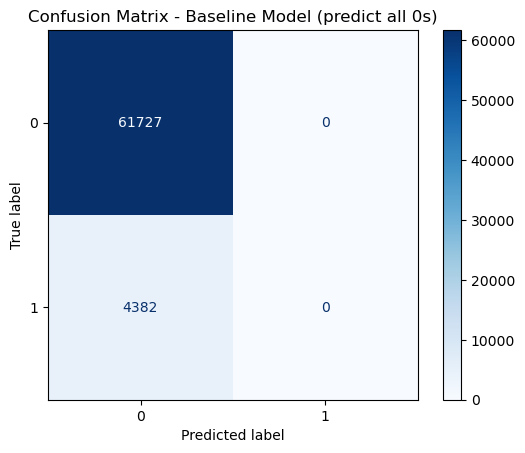


Percentage Improvement Compared to Baseline:
Precision Improvement: 67.86%
Recall Improvement: 42.24%
F1-Score Improvement: 153.96%

Model classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     61727
           1       0.79      0.65      0.72      4382

    accuracy                           0.97     66109
   macro avg       0.88      0.82      0.85     66109
weighted avg       0.96      0.97      0.96     66109



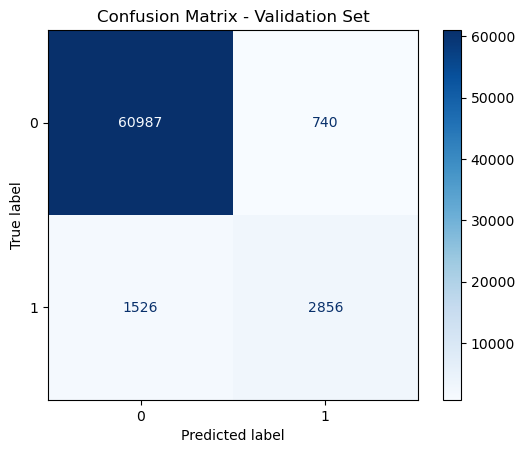

In [90]:
y_val_baseline = np.zeros_like(y_val)
baseline_report = classification_report(y_val, y_val_baseline, output_dict=True)
baseline_precision = baseline_report['macro avg']['precision']
baseline_recall = baseline_report['macro avg']['recall']
baseline_f1 = baseline_report['macro avg']['f1-score']

print("\nBaseline model classification report (predict all 0s):")
print(classification_report(y_val, y_val_baseline))

cm_baseline = confusion_matrix(y_val, y_val_baseline)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline)
disp_baseline.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Baseline Model (predict all 0s)")
plt.show()

print("\nPercentage Improvement Compared to Baseline:")
print(f"Precision Improvement: {((avg_precision - baseline_precision) / baseline_precision) * 100:.2f}%")
print(f"Recall Improvement: {((avg_recall - baseline_recall) / baseline_recall) * 100:.2f}%")
print(f"F1-Score Improvement: {(avg_f1 / baseline_f1) * 100:.2f}%")

print("\nModel classification report:")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

### Train Model on Test Dataset

In [91]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ensure no missing values
train_val[text_features + num_features + cat_features] = train_val[text_features + num_features + cat_features].fillna('')
test[text_features + num_features + cat_features] = test[text_features + num_features + cat_features].fillna('')

X = train_val[text_features + num_features + cat_features]
y = train_val['target']

X_test = test[text_features + num_features + cat_features]
y_test = test['target']

# Preprocessors
text_vectorizer = TfidfVectorizer()
num_scaler = StandardScaler()
cat_encoder = OneHotEncoder(handle_unknown='ignore')

# ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_vectorizer, 'combined_text'),
        ('num', num_scaler, num_features),
        ('cat', cat_encoder, cat_features)
    ],
    remainder='passthrough'  # To ensure no columns are dropped
)

# Logistic Regression Model
lr = LogisticRegression(
    C=1, 
    class_weight=None, 
    max_iter=25, 
    penalty='l1', 
    solver='liblinear', 
    tol=.001, 
    random_state=42
)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

# Fit the pipeline on the training/validation data
pipeline.fit(X, y)

# Predict on the test set
y_test_pred = pipeline.predict(X_test)

# Calculate and print test set scores
precision, recall, f1, accuracy = calculate_scores(y_test, y_test_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")



model_name = "TEST DF - Logistic Regression TFIDF Hypertuned (w) (score_change)"
note = "TEST DF - score_change, TFIDF Hypertuned combinedtext + word_count + news_desk + section_name"
save_model_scores(model_name, X_test, y_test, y_test_pred, note, output_file='model_scores.csv')

Precision: 0.7289, Recall: 0.5913, F1-Score: 0.6529, Accuracy: 0.9603


### Visualize Results for Logistic Regression

#### Baseline Summary

In [92]:
data = {
    'Metrics': [
        'Baseline Model: Random Choice with Probability (%)'
    ],
    'Precision (%)': [5.86],
    'Recall (%)': [5.85],
    'F1-Score (%)': [5.85],
    'Accuracy (%)': [89.56]
}

# Create a DataFrame
results_df = pd.DataFrame(data)

# Set the 'Model' column as the index
results_df.set_index('Metrics', inplace=True)
results_df.T

Metrics,Baseline Model: Random Choice with Probability (%)
Precision (%),5.86
Recall (%),5.85
F1-Score (%),5.85
Accuracy (%),89.56


#### Table Summary

In [82]:
data = {
    'Model': [
        'Baseline Model (Random Choice with Probability 0.06)',
        'Logistic Regression with CountVectorizer',
        'Logistic Regression with TfidfVectorizer',
        'Logistic Regression with TfidfVectorizer Fine-Tuned'
    ],
    'F1-Score (%)': [5.85, 65.87, 71.28, 73.71],
    'Precision (%)': [5.86, 70.63, 78.97, 77.97],
    'Recall (%)': [5.85, 62.04, 65.34, 70.27],
    'Accuracy (%)': [89.56, 96.14, 96.82, 96.96]
}

# Create a DataFrame
results_df = pd.DataFrame(data)

# Set the 'Model' column as the index
results_df.set_index('Model', inplace=True)
results_df

,F1-Score (%),Precision (%),Recall (%),Accuracy (%)
Model,,,,
Baseline Model (Random Choice with Probability 0.06),5.85,5.86,5.85,89.56
Logistic Regression with CountVectorizer,65.87,70.63,62.04,96.14
Logistic Regression with TfidfVectorizer,71.28,78.97,65.34,96.82
Logistic Regression with TfidfVectorizer Fine-Tuned,73.71,77.97,70.27,96.96


#### Plot

/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categoric

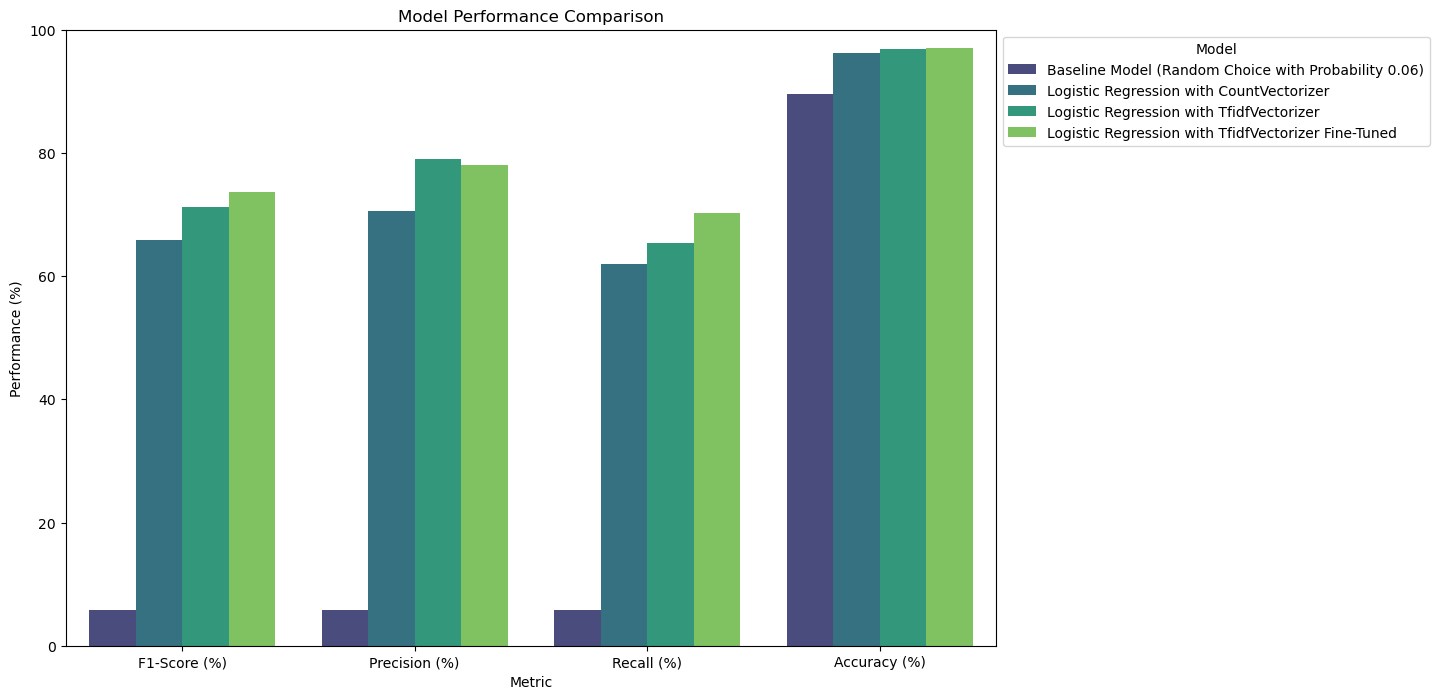

In [83]:
# Melt the DataFrame for easy plotting
melted_df = results_df.reset_index().melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 8))

# Create a custom palette for the bar plot
palette = sns.color_palette("viridis", len(results_df.index))

# Create the bar plot with adjusted opacity
sns.barplot(x='Metric', y='Score', hue='Model', data=melted_df, palette=palette)

# Set y-axis limits to 0-100%
plt.ylim(0, 100)

# Add title and labels
plt.title('Model Performance Comparison')
plt.xlabel('Metric')
plt.ylabel('Performance (%)')

# Move the legend to the top right corner, outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Model')

# Show the plot
plt.show()      

/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alecnaidoo/miniforge3/envs/python310mids/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26

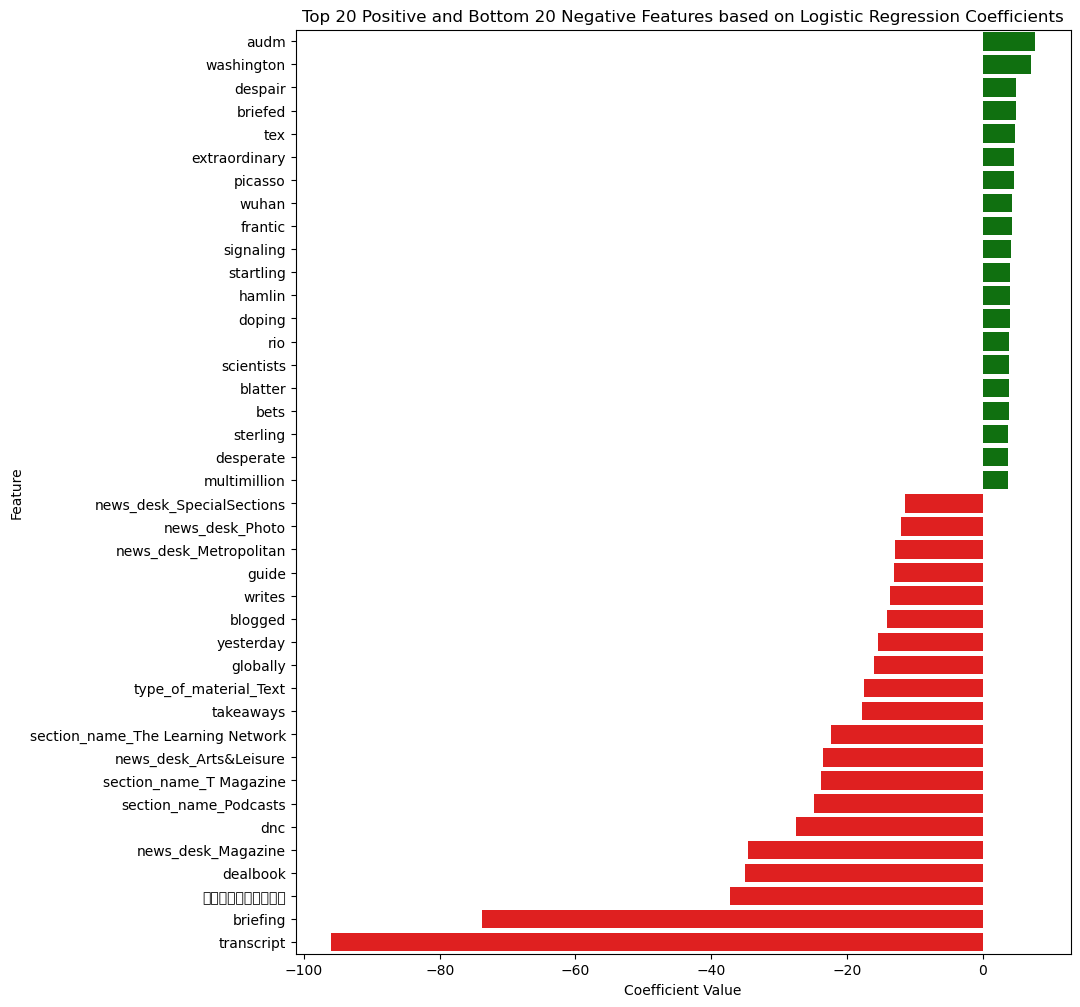

In [89]:
# Text features (from TfidfVectorizer)
text_feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(input_features=text_features)

# Numerical features (unchanged names after scaling)
num_feature_names = num_features  # These are the original numerical feature names

# Categorical features (from OneHotEncoder)
cat_feature_names = pipeline.named_steps['preprocessor'].transformers_[2][1].get_feature_names_out(input_features=cat_features)

# Combine all feature names in the correct order as they appear in the final 'features' vector
feature_names = list(text_feature_names) + list(num_feature_names) + list(cat_feature_names)

# Get the coefficients from the logistic regression model
coefficients = classifier.coef_.flatten()

# Create a DataFrame to organize the coefficients and feature names
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the coefficients by their actual value
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

# Select the top 20 positive and bottom 20 negative coefficients
top_20_positive = coeff_df.head(20)
bottom_20_negative = coeff_df.tail(20)

# Combine the top positive and bottom negative coefficients
top_bottom_coeff_df = pd.concat([top_20_positive, bottom_20_negative])

# Create colors for the bars: green for positive, red for negative
colors = top_bottom_coeff_df['Coefficient'].apply(lambda x: 'green' if x > 0 else 'red')

# Plot the top 20 and bottom 20 coefficients with customized colors
plt.figure(figsize=(10, 12))
sns.barplot(x='Coefficient', y='Feature', data=top_bottom_coeff_df, palette=colors)

# Add labels and title
plt.title('Top 20 Positive and Bottom 20 Negative Features based on Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

plt.show()